# Triple Loss Implementation

## Libary

In [1]:
import torch
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import tqdm

import numpy as np
from sklearn.manifold import TSNE
import random

## Model

In [2]:
class Simple_Network(nn.Module):
    def __init__(self, input_dim):
        super(Simple_Network, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 3)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x_ft = self.layer2(x)   
        x=F.relu(x_ft)
        x = F.softmax(self.layer3(x), dim=1)
        return x,x_ft
    
#The bottom network is just for easy visualization of Procedure Triplet Loss training (wth Cross Entropy)
class Simple_Modified_Network(nn.Module): 
    def __init__(self, input_dim):
        super(Simple_Modified_Network, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 2) ##For easy visualization we had set it to 2
        self.layer3 = nn.Linear(2, 3)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x_ft = self.layer2(x)   
        x=F.relu(x_ft)
        x = F.softmax(self.layer3(x), dim=1)
        return x,x_ft

## Data


In [3]:
#We Use Iris for fast experiment

iris=load_iris()
X=iris['data']
y=iris['target']
names=iris['target_names']
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
X_train,X_test,y_train,y_test =train_test_split(X_scaled,y,test_size=0.2,random_state=2)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).long()

In [4]:
print(f'Train Length: {X_train.shape[0]}')
print(f'Test Length: {X_test.shape[0]}')

Train Length: 120
Test Length: 30


## Common Hyper Parameter

In [5]:
MAX_EPOCH=150
learning_rate=0.01
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Training With Cross Entropy

In [6]:
loss_list=[]
accuracy_list_0=[]
criterion   = nn.CrossEntropyLoss()
model = Simple_Network(X_train.shape[1])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [7]:
for epoch in tqdm.trange(MAX_EPOCH):
    optimizer.zero_grad()

    output,_=model(X_train.to(device))
    loss=criterion(output,y_train.to(device))
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    with torch.no_grad():
        output,_=model(X_test.to(device))
        correct=(torch.argmax(output,dim=1) ==y_test.to(device)).type(torch.FloatTensor)
        accuracy_list_0.append(correct.mean())

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 193.88it/s]


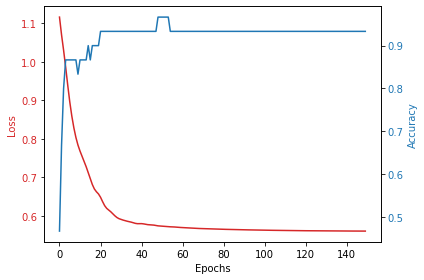

In [8]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(accuracy_list_0, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [9]:
print(accuracy_list_0[-1])

tensor(0.9333)


## Triplet Loss (wto Cross Entropy)

### Sampling Triplet

In [10]:
#Random Select One
def single_triplet(index_list,labels):
    anchor=random.sample(index_list,1)
    while True:
        pos=random.sample(index_list,1)
        if y_train[anchor] ==y_train[pos]:
            break
    while True:  
        neg=random.sample(index_list,1)
        if y_train[anchor] !=y_train[neg]:
            break
    return anchor,pos,neg

def sample_Triplet(batch_size,labels,x):
    
    try:
        x=x.numpy()
        labels=labels.numpy()
    except:
        pass
    
    index_list=np.arange(labels.shape[0]).tolist()
    xs=[]
    ys=[]
    for i in range(batch_size):
        a,p,n=single_triplet(index_list,labels)
       # print(x.shape)
        xs.append([x[a].reshape(-1),x[p].reshape(-1),x[n].reshape(-1)])
        ys.append([labels[a].reshape(-1),labels[p].reshape(-1),labels[n].reshape(-1)])
    return np.array(xs),np.array(ys).reshape(batch_size,-1)

##Example
input_,input_label=sample_Triplet(4,y_train,X_train)
print(f'Input Features (A,P,N): \n\n{input_}\n')
print(f'Related Labels (A,P,N): \n\n{input_label}')

Input Features (A,P,N): 

[[[ 1.0380048   0.09821729  0.36489627  0.26414192]
  [-0.4160097  -1.5131601   0.02387172 -0.13075463]
  [-1.021849    1.249201   -1.3402265  -1.3154444 ]]

 [[ 0.06866179  0.32841405  0.592246    0.79067063]
  [ 0.91683686 -0.13197948  0.36489627  0.26414192]
  [-1.021849    1.0190043  -1.2265517  -0.7889156 ]]

 [[ 1.0380048   0.09821729  1.0469455   1.5804638 ]
  [ 1.1591727   0.32841405  1.2174577   1.4488316 ]
  [-1.7488563  -0.13197948 -1.397064   -1.3154444 ]]

 [[-0.4160097  -1.7433568   0.13754657  0.13250974]
  [-0.17367394 -0.592373    0.194384    0.13250974]
  [ 0.31099755 -1.0527666   1.0469455   0.26414192]]]

Related Labels (A,P,N): 

[[1 1 0]
 [1 1 0]
 [2 2 0]
 [1 1 2]]


## Loss

In [11]:
def triplet(value, positive, negative, margin=0.2) : 
        d = nn.PairwiseDistance(p=2)
        distance = d(value, positive) - d(value, negative) + margin 
        loss = torch.mean(torch.max(distance, torch.zeros_like(distance))) 
        return loss


In [12]:
loss_list=[]
model = Simple_Modified_Network(X_train.shape[1])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_ft_list=[]
valid_ft_list=[]

In [13]:
for epoch in tqdm.trange(MAX_EPOCH):
    with torch.no_grad():
        output,output_Ft=model(X_train.to(device))
        train_ft_list.append(output_Ft.cpu().numpy())  
        output,output_Ft=model(X_test.to(device))
        valid_ft_list.append(output_Ft.cpu().numpy())
        
    input_,input_label=sample_Triplet(64,y_train,X_train)
    optimizer.zero_grad()
    anchor=torch.from_numpy(input_[:,0]).type(torch.FloatTensor)
    pos=torch.from_numpy(input_[:,1]).type(torch.FloatTensor)
    neg=torch.from_numpy(input_[:,2]).type(torch.FloatTensor)
    
    _,anchor_ft=model(anchor.to(device))
    _,pos_ft=model(pos.to(device))
    _,neg_ft=model(neg.to(device))
    loss=triplet(anchor_ft,pos_ft,neg_ft)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
with torch.no_grad():
    output,output_Ft=model(X_train.to(device))
    train_ft_list.append(output_Ft.cpu().numpy())  
    output,output_Ft=model(X_test.to(device))
    valid_ft_list.append(output_Ft.cpu().numpy())



100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 55.40it/s]


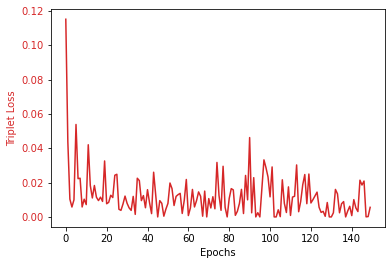

In [14]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Triplet Loss', color=color)
ax1.plot(loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)



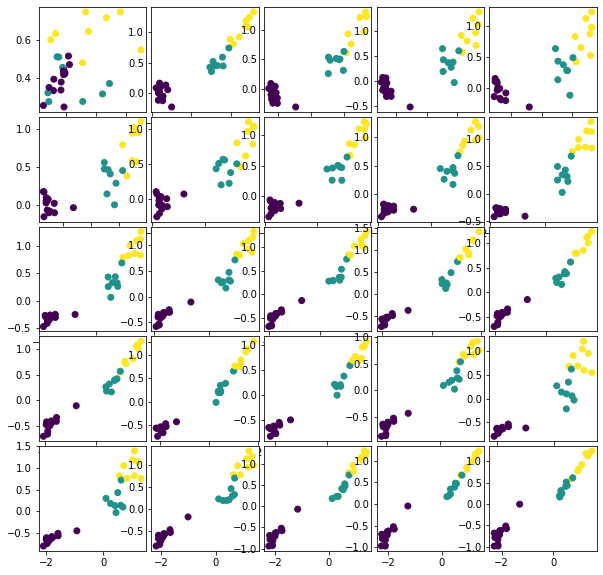

In [15]:
fig, axs = plt.subplots(5,5, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =0.05, wspace=.05)
axs = axs.ravel()
for i in range(25):
    index=i*6
    axs[i].scatter(valid_ft_list[index][:,0],valid_ft_list[index][:,1],c=y_test)
    #axs[i].scatter(train_ft_list[index][:,0],train_ft_list[index][:,1],c=y_train,marker="*")


## Triplet Loss (wt Cross Entropy)

In [16]:
triplet_loss_list=[]
entropy_loss_list=[]
accuracy_list_1=[]
criterion   = nn.CrossEntropyLoss()
model = Simple_Network(X_train.shape[1])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
alpha=10

In [17]:
for epoch in tqdm.trange(MAX_EPOCH):
    optimizer.zero_grad()
    
    input_,input_label=sample_Triplet(120,y_train,X_train)
    ##Triplet Loss Update
    
    
    anchor=torch.from_numpy(input_[:,0]).type(torch.FloatTensor)
    pos=torch.from_numpy(input_[:,1]).type(torch.FloatTensor)
    neg=torch.from_numpy(input_[:,2]).type(torch.FloatTensor)
    
    _,anchor_ft=model(anchor.to(device))
    _,pos_ft=model(pos.to(device))
    _,neg_ft=model(neg.to(device))
    t_loss=triplet(anchor_ft,pos_ft,neg_ft)
    triplet_loss_list.append(t_loss.item())
    

    output,_=model(X_train.to(device))
    e_loss=criterion(output,y_train.to(device))
    loss=e_loss+t_loss*alpha
    loss.backward()
    optimizer.step()
    entropy_loss_list.append(e_loss.item())
    with torch.no_grad():
        output,_=model(X_test.to(device))
        correct=(torch.argmax(output,dim=1) ==y_test.to(device)).type(torch.FloatTensor)
        accuracy_list_1.append(correct.mean())

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 32.44it/s]


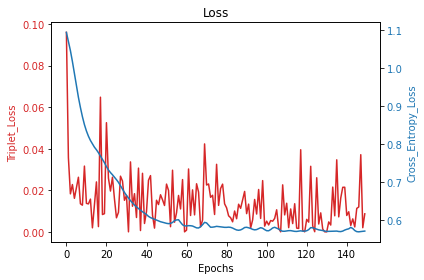

In [18]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Triplet_Loss', color=color)
ax1.plot(triplet_loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Cross_Entropy_Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(entropy_loss_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title("Loss")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

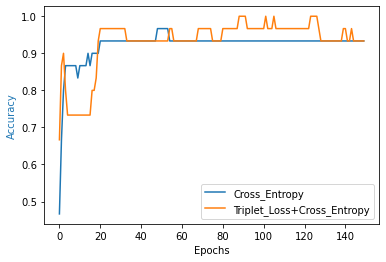

In [21]:
ax1.set_title("Accuracy")
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(accuracy_list_0,label="Cross_Entropy")
ax1.plot(accuracy_list_1,label="Triplet_Loss+Cross_Entropy")
ax1.legend()

plt.show()